# Описание проекта

## Стоимость поддержанного автомобиля

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становится особо актуальным, если речь идет про дорогие товары, например про автомобили! В рамках данной задачи необходимо поработать с данными о продажах автомобилей на вторичном рынке. Целью данного проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

## Основные этапы исследования

- Загрузка и ознакомление с данными, <p>
- Предварительная обработка,<p>
- Полноценный разведочный анализ,<p>
- Разработка новых синтетических признаков,<p>
- Проверка на мультиколлинеарность,<p>
- Отбор финального набора обучающих признаков,<p>
- Выбор и обучение моделей,<p>
- Итоговая оценка качества предсказания лучшей модели,<p>
- Анализ важности ее признаков.

# Представление данных

In [567]:
!pip install imblearn

In [568]:
!pip install catboost

In [569]:
# Импорт основных библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from catboost import CatBoostRegressor

from math import ceil

from pandas.api.types import is_string_dtype

from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

from imblearn.pipeline import Pipeline, make_pipeline

In [570]:
# Отключение лишних предупреждений
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [571]:
# Импорт датасета
try:
    sample_submission = pd.read_csv('datasets/sample_submission.csv')
    test = pd.read_csv('datasets/test.csv')
    train = pd.read_csv('datasets/train.csv')
except Exception as info:
    display(info)
    sample_submission = pd.read_csv('/kaggle/input/used-cars-price-prediction-19ds/sample_submission.csv')
    test = pd.read_csv('/kaggle/input/used-cars-price-prediction-19ds/test.csv')
    train = pd.read_csv('/kaggle/input/used-cars-price-prediction-19ds/train.csv')

In [572]:
# Объявим функцию для изучения датасетов
def describe_dataframe(dataframe):
    display(dataframe.head(10))
    display(dataframe.info())
    display(dataframe.describe(percentiles=[.5]).T)
    print(f"Количество дублированных строк: {dataframe.duplicated().sum()}")

In [573]:
describe_dataframe(train)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)
5,2013,Lincoln,MKZ,Base,Sedan,automatic,3ln6l2j91dr817800,mi,2.5,14894.0,black,black,"ford motor credit company,llc",22600,Thu May 21 2015 02:00:00 GMT-0700 (PDT)
6,2010,pontiac,g6,4c,NaN,automatic,1g2za5eb4a4157380,nc,3.4,114587.0,silver,black,north state acceptance,5900,Mon Jan 12 2015 09:30:00 GMT-0800 (PST)
7,2013,Ford,Escape,SE,SUV,automatic,1fmcu0gx3duc59421,fl,4.8,26273.0,blue,gray,fields bmw,15200,Tue Feb 03 2015 01:00:00 GMT-0800 (PST)
8,2000,Hyundai,Elantra,GLS,Sedan,automatic,kmhjf35f2yu955691,oh,1.9,182624.0,black,tan,dt inventory,700,Thu Jan 22 2015 01:00:00 GMT-0800 (PST)
9,2005,Ford,Freestyle,Limited,wagon,automatic,1fmdk06135ga45438,oh,1.0,149364.0,black,tan,wells fargo dealer services,325,Tue Jun 16 2015 05:00:00 GMT-0700 (PDT)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


None

,count,mean,std,min,50%,max
year,440236.0,2010.040101,3.977945,1982.0,2012.0,2015.0
condition,430831.0,3.425077,0.949973,1.0,3.6,5.0
odometer,440167.0,68344.421604,53542.203908,1.0,52098.0,999999.0
sellingprice,440236.0,13592.209588,9751.479098,1.0,12100.0,230000.0


Количество дублированных строк: 0


In [578]:
# train.query("odometer > 500000 and odometer < 10").drop(inplace=True)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
6069,2012,Hyundai,Sonata,GLS,Sedan,automatic,5npeb4ac6ch429831,oh,1.0,999999.0,white,gray,santander consumer,800,Tue Jan 06 2015 05:00:00 GMT-0800 (PST)
9830,2002,Saturn,VUE,Base,SUV,manual,5gzcz23d52s811182,md,4.7,694978.0,red,beige,autonation chevrolet timonium,1000,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
11122,2004,Chevrolet,Tahoe,LS,SUV,automatic,1gnec13v34j247109,ga,1.9,999999.0,black,tan,santander consumer,1800,Tue Jan 06 2015 01:30:00 GMT-0800 (PST)
12368,2006,Mazda,Tribute,i,SUV,automatic,4f2yz02z26km30632,fl,2.0,999999.0,white,tan,santander consumer,1200,Mon Feb 09 2015 01:30:00 GMT-0800 (PST)
14897,2006,Kia,Amanti,Base,Sedan,automatic,knald124265085150,ms,1.0,999999.0,gray,beige,fiserv/global lending services,800,Thu Dec 18 2014 12:02:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411526,2003,BMW,X5,3.0i,SUV,automatic,5uxfa53523lv91719,tx,2.7,999999.0,black,tan,santander consumer,3100,Wed Feb 18 2015 02:30:00 GMT-0800 (PST)
417666,2003,Chevrolet,Silverado 1500,LS,Extended Cab,automatic,1gcec19v43e225059,ca,2.0,999999.0,gray,gray,800 loan mart,700,Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
419146,2007,Chevrolet,Tahoe,LT,SUV,automatic,1gnfc13j97r145854,fl,1.9,999999.0,blue,gray,innovate loan servicing corp,6900,Thu Feb 12 2015 07:00:00 GMT-0800 (PST)
435430,2006,Dodge,Ram Pickup 2500,SLT,Quad Cab,automatic,3d7kr28c36g245006,la,NaN,500227.0,white,gray,don's wholesale llc,1500,Wed Dec 17 2014 12:00:00 GMT-0800 (PST)


In [496]:
describe_dataframe(test)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)
5,2003,Volkswagen,Passat,GLS 1.8T,wagon,automatic,wvwvd63b93e175638,nc,2.4,104155.0,silver,black,fred anderson nissan of fayetteville,Tue Jun 09 2015 03:00:00 GMT-0700 (PDT)
6,2013,Hyundai,Sonata,GLS,Sedan,automatic,5npeb4ac4dh809686,il,3.7,30669.0,silver,gray,merchants leasing,Tue Mar 03 2015 02:00:00 GMT-0800 (PST)
7,2013,Ford,Explorer,Base,SUV,automatic,1fm5k7b97dgb16454,nc,3.2,87862.0,black,gray,ge fleet services for itself/servicer,Tue Feb 10 2015 01:15:00 GMT-0800 (PST)
8,2011,Infiniti,G Sedan,G37x,G Sedan,automatic,jn1cv6ar5bm411441,tn,3.5,47028.0,black,beige,nissan infiniti lt,Wed Feb 04 2015 02:30:00 GMT-0800 (PST)
9,2007,Chevrolet,Suburban,1500 LS,SUV,automatic,3gnfc16j77g158033,ga,3.4,191211.0,black,tan,riverside chevrolet inc,Tue Feb 10 2015 04:30:00 GMT-0800 (PST)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


None

,count,mean,std,min,50%,max
year,110058.0,2010.060005,3.960190,1982.0,2012.0,2015.0
condition,107679.0,3.423222,0.951301,1.0,3.6,5.0
odometer,110039.0,68074.331601,53520.988173,1.0,51922.0,999999.0


Количество дублированных строк: 0


In [497]:
# Рассмотрим корреляции численных данных
corr = train[['year', 'condition', 'odometer', 'sellingprice']].corr()
corr.style.background_gradient(cmap='coolwarm')

,year,condition,odometer,sellingprice
year,1.000000,0.553403,-0.774498,0.586847
condition,0.553403,1.000000,-0.540544,0.538906
odometer,-0.774498,-0.540544,1.000000,-0.583044
sellingprice,0.586847,0.538906,-0.583044,1.000000


# Предобработка данных

In [498]:
# Сохраним первоначальные датафреймы для сравнения чистых и обработанных данных
raw_train = train.copy(deep=True)
raw_test = test.copy(deep=True)

In [499]:
# Все пропущенные значения на экране
train.isna().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

In [500]:
# Преобразуем колонку с датой продажи к формату datetime
# train['odometer'] = np.floor(pd.to_numeric(train['odometer'], errors='coerce')).astype('Int64')
train['sellingprice'] = np.floor(pd.to_numeric(train['sellingprice'], errors='coerce')).astype('Int32')
train['condition'] = np.floor(pd.to_numeric(train['condition'], errors='coerce')).astype('Float64')

# test['odometer'] = np.floor(pd.to_numeric(test['odometer'], errors='coerce')).astype('Int64')
test['condition'] = np.floor(pd.to_numeric(test['condition'], errors='coerce')).astype('Float64')

train['saledate'] = pd.to_datetime(train['saledate'].str[:-15], format="%a %b %d %Y %H:%M:%S")
test['saledate'] = pd.to_datetime(test['saledate'].str[:-15], format="%a %b %d %Y %H:%M:%S")

# train['year'] = pd.to_datetime(train['year'], format="%Y")
# test['year'] = pd.to_datetime(test['year'], format="%Y")

In [501]:
# Изучим марки автомобилей

train['make'] = train['make'].str.capitalize()
display(f"Первоначальное число уникальных марок автомобилей: {train['make'].value_counts().count()}")
train['make'].value_counts()

'Первоначальное число уникальных марок автомобилей: 62'

Ford         74067
Chevrolet    47818
Nissan       42866
Toyota       31711
Dodge        24294
             ...  
Daewoo           1
Dodge tk         1
Mazda tk         1
Dot              1
Airstream        1
Name: make, Length: 62, dtype: int64

In [502]:
def make_unique(data):
    if not data or data in ['none', 'nan']:
        return 'Other'
    data = str(data)
    if data.find("ford") != -1:
        return "ford"
    elif data.find("gmc") != -1:
        return "gmc"
    elif data.find("land") != -1 and data.find("rover") != -1:
        return "landrover"
    elif data.find("mercedes") != -1:
        return "mercedes"
    elif data == "vw":
        return "volkswagen"
    elif data.find("dodge") != -1:
        return "dodge"
    elif data.find("mazda") != -1:  #  Hyundai
        return "mazda"
    elif data.find("hyundai") != -1:
        return "hyundai"
    else:
        return data

In [503]:
def body_unique(data):
    if not data or data in ['none', 'nan']:
        return 'Other'
    data = str(data)
    if data.find("cab") != -1 or data.find("crew") != -1:
        return "pick-up"
    if data.find("convertible") != -1:
        return "convertible"
    if data.find("coupe") != -1 or data.find("koup") != -1:
        return "coupe"
    if data.find("wagon") != -1:
        return "wagon"
    if data.find("van") != -1:
        return "van"
    if data.find("sedan") != -1:
        return "sedan"
    else:
        return data

In [504]:
train['make'] = train['make'].str.lower().apply(make_unique).str.capitalize()
train['make'].value_counts()

Ford            74070
Chevrolet       47818
Nissan          42866
Toyota          31711
Dodge           24295
Honda           21600
Hyundai         17187
Bmw             16254
Kia             14325
Chrysler        13796
Mercedes        13408
Infiniti        12123
Jeep            12107
Volkswagen       9901
Lexus            9363
Gmc              8368
Nan              8043
Mazda            6704
Cadillac         5958
Acura            4679
Audi             4635
Lincoln          4541
Buick            4023
Subaru           4019
Pontiac          3596
Ram              3592
Mitsubishi       3413
Volvo            2958
Mini             2473
Saturn           2247
Mercury          1561
Landrover        1476
Scion            1338
Jaguar           1100
Porsche          1094
Suzuki            846
Fiat              672
Hummer            597
Saab              384
Smart             311
Oldsmobile        294
Isuzu             163
Maserati          112
Bentley            91
Aston martin       23
Plymouth  

In [505]:
test['make'] = test['make'].str.lower().apply(make_unique).str.capitalize()
test['make'].value_counts()

Ford            18466
Chevrolet       11801
Nissan          10485
Toyota           7728
Dodge            6188
Honda            5382
Hyundai          4410
Bmw              4136
Kia              3571
Mercedes         3471
Chrysler         3459
Jeep             3069
Infiniti         3002
Volkswagen       2515
Lexus            2430
Nan              2061
Gmc              2059
Mazda            1676
Cadillac         1496
Lincoln          1153
Acura            1151
Audi             1124
Buick            1019
Subaru           1015
Ram               889
Pontiac           866
Mitsubishi        806
Volvo             765
Mini              674
Saturn            544
Mercury           434
Landrover         371
Scion             318
Jaguar            297
Porsche           280
Suzuki            222
Fiat              181
Hummer            174
Saab               93
Oldsmobile         88
Smart              81
Isuzu              38
Bentley            23
Maserati           21
Tesla               6
Plymouth  

In [506]:
train['body'] = train['body'].str.lower().apply(body_unique).str.capitalize()
train['body'].value_counts()

Sedan          196720
Suv            113042
Pick-up         37243
Van             25146
Hatchback       20715
Coupe           15791
Wagon           12639
Nan             10393
Convertible      8547
Name: body, dtype: int64

In [507]:
test['body'] = test['body'].str.lower().apply(body_unique).str.capitalize()
test['body'].value_counts()

Sedan          48970
Suv            28295
Pick-up         9202
Van             6414
Hatchback       5152
Coupe           3995
Wagon           3287
Nan             2594
Convertible     2149
Name: body, dtype: int64

In [508]:
train['model'] = train['model'].str.capitalize()
train['model'].fillna("Unknown", inplace=True)
train['model'].value_counts()

Altima            15454
F-150             11408
Fusion            10244
Camry             10000
Escape             9447
                  ...  
420-class             1
C230                  1
Rrs                   1
Activehybrid 5        1
G500                  1
Name: model, Length: 840, dtype: int64

In [509]:
test['model'] = test['model'].str.capitalize()
test['model'].fillna("Unknown", inplace=True)
test['model'].value_counts()

Altima           3736
F-150            2737
Fusion           2553
Camry            2423
Escape           2296
                 ... 
Exige               1
1                   1
C240w               1
Accord hybrid       1
Caprice             1
Name: model, Length: 747, dtype: int64

In [510]:
train['trim'] = train['trim'].str.capitalize()
train['trim'].fillna("Unknown", inplace=True)
train['trim'].value_counts()

Base                      43876
Se                        34498
Lx                        16511
Limited                   14516
Lt                        13431
                          ...  
Executive pzev                1
4c base                       1
3500 sh ceiling 158 wb        1
Chevy van base                1
4x4 v6 xlt sport              1
Name: trim, Length: 1851, dtype: int64

In [511]:
test['trim'] = test['trim'].str.capitalize()
test['trim'].fillna("Unknown", inplace=True)
test['trim'].value_counts()

Base                11009
Se                   8725
Lx                   4098
Limited              3536
Lt                   3280
                    ...  
4wd s                   1
Hx                      1
Gr tr gr touring        1
Mr touring              1
Awd xs ll bean          1
Name: trim, Length: 1458, dtype: int64

In [512]:
train['transmission'].value_counts()

automatic    375061
manual        13714
Name: transmission, dtype: int64

In [513]:
# grouped_cars = train.groupby(['make', 'model'])
# # most_common_transmission = train.groupby(['make', 'model'])['transmission'].value_counts()
# for name, group in grouped_cars:
#     most_common_transmission = group['transmission'].value_counts()
#     try:
#         display(f"Most common category in group {name}: {most_common_transmission.index[0]}")
#     except:
#         continue

In [514]:
train['transmission'] = train['transmission'].fillna(
    train.groupby(['make', 'model'])['transmission'].transform(
        lambda x: x.fillna(x.iloc[round(len(x) / 2)])
    )
)

train['transmission'].fillna("unknown", inplace=True)
train['transmission'].value_counts()

automatic    415262
manual        16443
unknown        8531
Name: transmission, dtype: int64

In [515]:
test['transmission'] = test['transmission'].fillna(
    test.groupby(['make', 'model'])['transmission'].transform(
        lambda x: x.fillna(x.iloc[round(len(x) / 2)])
    )
)
test['transmission'].fillna("unknown", inplace=True)
test['transmission'].value_counts()

automatic    103876
manual         3787
unknown        2395
Name: transmission, dtype: int64

In [516]:
train['color'].fillna("—", inplace=True)
train['color'].value_counts()

black        87115
white        84149
silver       65667
gray         65284
blue         40237
red          34514
—            20106
green         8975
gold          8934
beige         7257
burgundy      7059
brown         5320
orange        1629
purple        1250
off-white     1143
yellow         979
charcoal       389
turquoise      183
pink            32
lime            14
Name: color, dtype: int64

In [517]:
test['color'].fillna("—", inplace=True)
test['color'].value_counts()

black        22006
white        20928
silver       16360
gray         16348
blue         10180
red           8384
—             5106
green         2270
gold          2207
beige         1826
burgundy      1759
brown         1300
orange         407
purple         284
off-white      275
yellow         274
charcoal        84
turquoise       49
pink            10
lime             1
Name: color, dtype: int64

In [518]:
train['interior'].fillna("—", inplace=True)
train['interior'].value_counts()

black        192442
gray         140843
beige         46878
tan           34709
—             14149
brown          6818
red            1070
blue            885
silver          844
off-white       373
purple          276
gold            256
white           215
green           198
burgundy        155
orange          109
yellow           16
Name: interior, dtype: int64

In [519]:
test['interior'].fillna("—", inplace=True)
test['interior'].value_counts()

black        48176
gray         34984
beige        11931
tan           8658
—             3538
brown         1664
red            264
blue           241
silver         225
off-white      107
gold            64
purple          58
green           44
burgundy        34
orange          33
white           33
yellow           4
Name: interior, dtype: int64

In [520]:
train['condition'].fillna(train.groupby(['make', 'body', 'trim', 'model'])['condition'].transform('median'), inplace=True)
train['condition'].fillna(train.groupby(['make'])['condition'].transform('median'), inplace=True)
train['condition'] = np.round(train['condition'], decimals = 1)
train['condition'].value_counts()

4.0    142593
3.0    139473
2.0    108832
1.0     40302
5.0      8862
2.5        85
1.5        76
3.5        13
Name: condition, dtype: Int64

In [521]:
test['condition'].fillna(train.groupby(['make', 'body', 'trim', 'model'])['condition'].transform('median'), inplace=True)
test['condition'].fillna(train.groupby(['make'])['condition'].transform('median'), inplace=True)
test['condition'] = np.round(train['condition'], decimals = 1)
test['condition'].value_counts()

4.0    35434
3.0    35037
2.0    27153
1.0    10202
5.0     2196
2.5       21
1.5       13
3.5        2
Name: condition, dtype: Int64

In [522]:
train['odometer'].fillna(train.groupby(['make', 'body', 'model'])['odometer'].transform('mean'), inplace=True)

In [523]:
test['odometer'].fillna(train.groupby(['make', 'body', 'model'])['odometer'].transform('mean'), inplace=True)

In [524]:
train.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
dtype: int64

In [525]:
test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
dtype: int64

# Добавление синтетических данных

In [526]:
def get_car_type(price):
    if price <= 5400:
        return 'lowcost'
    elif price >= 20000:
        return 'premium'
    else:
        return 'standard'

In [527]:
train['saledate_week_day'] = train['saledate'].dt.weekday
# train['saledate_month'] = train['saledate'].dt.month
# train['saledate_year'] = train['saledate'].dt.year
train['car_age'] = train['saledate'].dt.year - train['year']
train['type'] = train.sellingprice.transform(get_car_type)

In [528]:
test['saledate_week_day'] = test['saledate'].dt.weekday
# test['saledate_month'] = test['saledate'].dt.month
# test['saledate_year'] = test['saledate'].dt.year
test['car_age'] = test['saledate'].dt.year - test['year']
test['type'] = None

In [529]:
test['type'].fillna(
    train.groupby(['body', 'model'])['type'].transform(
        lambda x: x.fillna(x.iloc[round(len(x) / 2)])
    ),
    inplace=True
)
test['type'].fillna("unknown", inplace=True)

In [530]:
train.drop(columns=[
    'vin',
    # 'seller',
    'saledate',
    'year'
], inplace=True)

In [531]:
test.drop(columns=[
    'vin',
    # 'seller',
    'saledate',
    'year'
], inplace=True)

In [532]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\APMuravev\AppData\Local\Temp\ipykernel_18000\4185598760.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


,condition,odometer,sellingprice,saledate_week_day,car_age
condition,1.000000,-0.527190,0.523231,0.047086,-0.535608
odometer,-0.527190,1.000000,-0.583041,-0.072474,0.772388
sellingprice,0.523231,-0.583041,1.000000,0.084767,-0.584540
saledate_week_day,0.047086,-0.072474,0.084767,1.000000,-0.044426
car_age,-0.535608,0.772388,-0.584540,-0.044426,1.000000


# Исследовательский анализ данных

In [533]:
train['sellingprice'].quantile([0.025, 0.975], interpolation='nearest')

0.025      850
0.975    36500
Name: sellingprice, dtype: Int32

# Подбор и обучение моделей машинного обучения

In [534]:
target_train = train['sellingprice']
features_train = train.drop(['sellingprice'], axis=1)

In [535]:
features_test = test

In [536]:
categorical_columns = list(filter(lambda column: is_string_dtype(features_train[column]), features_train.columns))
numeric_columns = list(filter(lambda column: not is_string_dtype(features_train[column]), features_train.columns))

In [537]:
categorical_columns

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'state',
 'color',
 'interior',
 'seller',
 'type']

In [538]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(features_train[categorical_columns])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [539]:
features_train_encoded = pd.DataFrame(
    encoder.transform(features_train[categorical_columns]), # .toarray()
    columns=encoder.get_feature_names_out(categorical_columns),
)
features_train = pd.concat((features_train[numeric_columns], features_train_encoded), axis=1)

In [540]:
features_train.head()

,condition,odometer,saledate_week_day,car_age,make,model,trim,body,transmission,state,color,interior,seller,type
0,4.0,111041.0,1,4,16.0,242.0,1410.0,6.0,0.0,12.0,1.0,1.0,10697.0,2.0
1,3.0,31034.0,2,1,16.0,321.0,1379.0,5.0,0.0,15.0,1.0,1.0,736.0,2.0
2,2.0,35619.0,2,3,38.0,667.0,69.0,5.0,0.0,19.0,1.0,1.0,8503.0,2.0
3,2.0,131301.0,2,12,20.0,383.0,581.0,6.0,0.0,33.0,6.0,0.0,12845.0,2.0
4,2.0,127709.0,1,8,16.0,321.0,1410.0,5.0,0.0,12.0,1.0,1.0,9750.0,0.0


In [541]:
features_test_encoded = pd.DataFrame(
    encoder.transform(features_test[categorical_columns]), # .toarray()
    columns=encoder.get_feature_names_out(categorical_columns),
)
features_test = pd.concat((features_test[numeric_columns], features_test_encoded), axis=1)

In [542]:
describe_dataframe(features_test)

,condition,odometer,saledate_week_day,car_age,make,model,trim,body,transmission,state,color,interior,seller,type
0,4.0,116970.0,2,10,7.0,203.0,581.0,5.0,0.0,3.0,15.0,1.0,7066.0,2.0
1,3.0,6286.0,4,1,18.0,661.0,177.0,7.0,0.0,28.0,17.0,6.0,12270.0,2.0
2,2.0,11831.0,1,2,38.0,513.0,1324.0,6.0,0.0,24.0,7.0,1.0,8503.0,2.0
3,2.0,57105.0,4,2,8.0,397.0,1124.0,5.0,0.0,5.0,15.0,1.0,8730.0,2.0
4,2.0,31083.0,2,2,38.0,742.0,1563.0,4.0,0.0,32.0,1.0,1.0,8477.0,0.0
5,2.0,104155.0,1,12,53.0,540.0,951.0,8.0,0.0,17.0,15.0,1.0,4884.0,1.0
6,3.0,30669.0,1,2,21.0,700.0,949.0,5.0,0.0,8.0,15.0,6.0,7787.0,2.0
7,4.0,87862.0,1,2,16.0,285.0,581.0,6.0,0.0,17.0,1.0,6.0,5071.0,2.0
8,1.0,47028.0,2,4,22.0,330.0,918.0,5.0,0.0,32.0,1.0,0.0,8472.0,0.0
9,1.0,191211.0,1,8,8.0,723.0,47.0,6.0,0.0,6.0,1.0,13.0,10389.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   condition          110058 non-null  Float64
 1   odometer           110058 non-null  float64
 2   saledate_week_day  110058 non-null  int64  
 3   car_age            110058 non-null  int64  
 4   make               110058 non-null  float64
 5   model              110058 non-null  float64
 6   trim               110058 non-null  float64
 7   body               110058 non-null  float64
 8   transmission       110058 non-null  float64
 9   state              110058 non-null  float64
 10  color              110058 non-null  float64
 11  interior           110058 non-null  float64
 12  seller             110058 non-null  float64
 13  type               110058 non-null  float64
dtypes: Float64(1), float64(11), int64(2)
memory usage: 11.9 MB


None

,count,mean,std,min,50%,max
condition,110058.0,2.929492,1.007287,1.0,3.0,5.0
odometer,110058.0,68075.991622,53517.960035,1.0,51932.5,999999.0
saledate_week_day,110058.0,2.14287,1.044089,0.0,2.0,6.0
car_age,110058.0,4.842747,3.938529,-1.0,3.0,33.0
make,110058.0,23.73901,14.687269,-1.0,19.0,54.0
model,110058.0,385.438024,236.984876,-1.0,330.0,839.0
trim,110058.0,1044.418434,483.230212,-1.0,1118.0,1850.0
body,110058.0,4.949236,1.557104,0.0,5.0,8.0
transmission,110058.0,0.077932,0.339679,0.0,0.0,2.0
state,110058.0,16.207945,11.538929,0.0,14.0,37.0


Количество дублированных строк: 0


In [543]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = pd.DataFrame(
    scaler.transform(features_train),
    columns=features_train.columns,
    index=features_train.index)

In [544]:
describe_dataframe(features_train)

,condition,odometer,saledate_week_day,car_age,make,model,trim,body,transmission,state,color,interior,seller,type
0,1.059178,0.797397,-1.089094,-0.218090,-0.527942,-0.605503,0.753410,0.681573,-0.230446,-0.361429,-1.263168,-0.707477,1.110114,0.756587
1,0.066029,-0.696936,-0.131164,-0.976742,-0.527942,-0.272387,0.689375,0.036378,-0.230446,-0.101577,-1.263168,-0.707477,-1.563574,0.756587
2,-0.927120,-0.611299,-0.131164,-0.470974,0.965347,1.186576,-2.016637,0.036378,-0.230446,0.244892,-1.263168,-0.707477,0.521210,0.756587
3,-0.927120,1.175804,-0.131164,1.804982,-0.256435,-0.010954,-0.959020,0.681573,-0.230446,1.457534,-0.512360,-0.941260,1.686671,0.756587
4,-0.927120,1.108715,-1.089094,0.793446,-0.527942,-0.272387,0.753410,0.036378,-0.230446,-0.361429,-1.263168,-0.707477,0.855924,-1.740090
5,-0.927120,-0.998391,0.826766,-0.723858,0.422333,0.473961,-0.959020,0.036378,-0.230446,-0.274811,-1.263168,-0.707477,-0.471659,-0.491752
6,0.066029,0.863628,-2.047024,0.034794,1.168977,-0.175404,-1.465106,-1.254011,-0.230446,0.071658,0.839093,-0.707477,0.534899,0.756587
7,1.059178,-0.785860,-1.089094,-0.723858,-0.527942,-0.479003,0.689375,0.681573,-0.230446,-0.967750,-1.113006,0.461438,-0.551379,0.756587
8,-1.920269,2.134391,0.826766,2.563634,-0.188558,-0.588636,-0.198858,0.036378,-0.230446,0.677979,-1.263168,2.097919,-0.715649,-1.740090
9,-1.920269,1.513177,-1.089094,1.299214,-0.527942,-0.280820,0.110991,1.971961,-0.230446,0.677979,-1.263168,2.097919,1.653656,-1.740090


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   condition          440236 non-null  float64
 1   odometer           440236 non-null  float64
 2   saledate_week_day  440236 non-null  float64
 3   car_age            440236 non-null  float64
 4   make               440236 non-null  float64
 5   model              440236 non-null  float64
 6   trim               440236 non-null  float64
 7   body               440236 non-null  float64
 8   transmission       440236 non-null  float64
 9   state              440236 non-null  float64
 10  color              440236 non-null  float64
 11  interior           440236 non-null  float64
 12  seller             440236 non-null  float64
 13  type               440236 non-null  float64
dtypes: float64(14)
memory usage: 47.0 MB


None

,count,mean,std,min,50%,max
condition,440236.0,-8.244333e-17,1.000001,-1.920269,0.066029,2.052328
odometer,440236.0,1.329939e-16,1.000001,-1.276556,-0.303400,17.400938
saledate_week_day,440236.0,1.131417e-16,1.000001,-2.047024,-0.131164,3.700556
car_age,440236.0,-1.096312e-16,1.000001,-1.482510,-0.470974,7.115546
make,440236.0,6.518963e-17,1.000001,-1.613969,-0.324311,2.051374
model,440236.0,2.441988e-17,1.000001,-1.625934,-0.234437,1.911841
trim,440236.0,-2.056241e-16,1.000001,-2.159167,0.150238,1.662300
body,440236.0,-6.017008e-17,1.000001,-3.189594,0.036378,1.971961
transmission,440236.0,-3.712210e-18,1.000001,-0.230446,-0.230446,5.825404
state,440236.0,8.589730e-17,1.000001,-1.400836,-0.188194,1.804003


Количество дублированных строк: 0


In [545]:
features_test = pd.DataFrame(
    scaler.transform(features_test),
    columns=features_test.columns,
    index=features_test.index)

In [546]:
describe_dataframe(features_test)

,condition,odometer,saledate_week_day,car_age,make,model,trim,body,transmission,state,color,interior,seller,type
0,1.059178,0.908137,-0.131164,1.299214,-1.138832,-0.769952,-0.959020,0.036378,-0.230446,-1.140984,0.839093,-0.707477,0.135497,0.756587
1,0.066029,-1.159167,1.784696,-0.976742,-0.392188,1.161276,-1.793545,1.326767,-0.230446,1.024448,1.139416,0.461438,1.532332,0.756587
2,-0.927120,-1.055600,-1.089094,-0.723858,0.965347,0.537211,0.575764,0.681573,-0.230446,0.677979,-0.362199,-0.707477,0.521210,0.756587
3,-0.927120,-0.209994,1.784696,-0.723858,-1.070956,0.048079,0.162632,0.036378,-0.230446,-0.967750,0.839093,-0.707477,0.582140,0.756587
4,-0.927120,-0.696021,-0.131164,-0.723858,0.965347,1.502825,1.069456,-0.608816,-0.230446,1.370917,-1.263168,-0.707477,0.514231,-1.740090
5,-0.927120,0.668784,-1.089094,1.804982,1.983498,0.651061,-0.194727,1.971961,-0.230446,0.071658,0.839093,-0.707477,-0.450186,-0.491752
6,0.066029,-0.703753,-1.089094,-0.723858,-0.188558,1.325726,-0.198858,0.036378,-0.230446,-0.707898,0.839093,0.461438,0.329024,0.756587
7,1.059178,0.364471,-1.089094,-0.723858,-0.527942,-0.424187,-0.959020,0.681573,-0.230446,0.071658,-1.263168,0.461438,-0.399992,0.756587
8,-1.920269,-0.398207,-0.131164,-0.218090,-0.120681,-0.234437,-0.262893,0.036378,-0.230446,1.370917,-1.263168,-0.941260,0.512889,-1.740090
9,-1.920269,2.294775,-1.089094,0.793446,-1.070956,1.422709,-2.062081,0.681573,-0.230446,-0.881132,-1.263168,2.097919,1.027442,-1.740090


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   condition          110058 non-null  float64
 1   odometer           110058 non-null  float64
 2   saledate_week_day  110058 non-null  float64
 3   car_age            110058 non-null  float64
 4   make               110058 non-null  float64
 5   model              110058 non-null  float64
 6   trim               110058 non-null  float64
 7   body               110058 non-null  float64
 8   transmission       110058 non-null  float64
 9   state              110058 non-null  float64
 10  color              110058 non-null  float64
 11  interior           110058 non-null  float64
 12  seller             110058 non-null  float64
 13  type               110058 non-null  float64
dtypes: float64(14)
memory usage: 11.8 MB


None

,count,mean,std,min,50%,max
condition,110058.0,-0.003996,1.000386,-1.920269,0.066029,2.052328
odometer,110058.0,-0.005083,0.999583,-1.276556,-0.306603,17.400938
saledate_week_day,110058.0,0.005696,1.000164,-2.047024,-0.131164,3.700556
car_age,110058.0,-0.004973,0.995991,-1.482510,-0.470974,7.115546
make,110058.0,-0.002643,0.996924,-1.681846,-0.324311,2.051374
model,110058.0,-0.000674,0.999284,-1.630150,-0.234437,1.911841
trim,110058.0,-0.001756,0.998188,-2.161233,0.150238,1.662300
body,110058.0,0.003626,1.004635,-3.189594,0.036378,1.971961
transmission,110058.0,0.005525,1.028523,-0.230446,-0.230446,5.825404
state,110058.0,0.003052,0.999471,-1.400836,-0.188194,1.804003


Количество дублированных строк: 0


In [547]:
kf = KFold(n_splits=3, random_state=32123, shuffle=True)
params = {
    'criterion': ['absolute_error', 'squared_error', 'poisson', 'friedman_mse'],
    'max_depth': range(2, 11, 4),
    'random_state': [32123]
}
dt_pipeline = make_pipeline(DecisionTreeRegressor())

In [548]:
# grid_rf = GridSearchCV(
#     RandomForestRegressor(),
#     param_grid=params,
#     cv=kf,
#     scoring='neg_mean_absolute_percentage_error',
#     # n_jobs=-1,
#     return_train_score=True)

In [549]:
# grid_rf.fit(features_train, target_train)
# grid_rf.best_params_

In [550]:
# grid_rf.best_score_

In [551]:
# from sklearn.model_selection import train_test_split
# # from catboost import Pool, cv
#
# # model = DecisionTreeRegressor(
# #     criterion='absolute_error',
# #     max_depth=16,
# #     random_state=32123
# # )
#
# features_train1, features_test1, target_train1, target_test1 = train_test_split(
#     features_train, target_train,test_size=0.25, random_state=42)
#
# cat = CatBoostRegressor(
#     iterations=1000,
#     depth=2,
#     loss_function="RMSE"
# )
# cat.fit(features_train1,target_train1,verbose=False, plot=True)

In [552]:
# from catboost import Pool, cv
#
# params = {"iterations": 1000,
#           "depth": 2,
#           "loss_function": "RMSE",
#           "verbose": False}
# cv_dataset = Pool(data=features_train1,
#                   label=target_train1)
# scores = cv(cv_dataset,
#             params,
#             fold_count=2,
#             plot="True")

In [553]:
# submission = grid_rf.predict(features_test)
# # mean_absolute_percentage_error(submission, target_test)

In [554]:
# sample_submission['sellingprice'] = submission
# sample_submission.to_csv('sample_submission.csv', index=False)

In [555]:
parameters = {'max_depth':[2, 3, 5, 7, 10],
              'min_samples_split':[2, 3, 4, 5],
              'min_samples_leaf':[1, 2, 3, 4]}
grid_dt = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid=parameters,
    cv=kf,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=2,
    return_train_score=True)

In [556]:
grid_dt.fit(features_train, target_train)
grid_dt.best_params_

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}

In [557]:
grid_dt.best_score_

-0.2692106234151197

In [561]:
model = DecisionTreeRegressor(
    # criterion='absolute_error',
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=2
)
model.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=4)

In [563]:
submission = model.predict(features_test)
#mean_absolute_percentage_error(submission, target_train)

In [564]:
sample_submission['sellingprice'] = submission
sample_submission.to_csv('sample_submission.csv', index=False)

In [483]:
lin_regressor = LinearRegression()
lin_regressor.fit(features_train, target_train)

list(zip(features_train.columns, lin_regressor.coef_))

[('condition', 2552.3158587179073),
 ('odometer', -2670.7245914341033),
 ('saledate_week_day', 482.55053396708865),
 ('car_age', -3587.593530139413),
 ('make', -553.6790298798558),
 ('model', 397.3277796267564),
 ('trim', -79.61513489532945),
 ('body', -384.67237162782806),
 ('transmission', 95.64818804873688),
 ('state', -122.80790659938212),
 ('color', -257.89367904986875),
 ('interior', -132.8415627656932),
 ('seller', 36.15823226416714),
 ('type', -2359.092864504534)]

In [484]:
from sklearn.linear_model import LassoCV, Lasso

Best alpha: 1


[('condition', 2551.5282392657195),
 ('odometer', -2670.511973199199),
 ('saledate_week_day', 481.4437775914954),
 ('car_age', -3585.739556404423),
 ('make', -552.2776961701629),
 ('model', 395.9149769781778),
 ('trim', -78.47494059268396),
 ('body', -383.5058392030895),
 ('transmission', 94.73309448929031),
 ('state', -121.58117172750654),
 ('color', -256.84511670060095),
 ('interior', -132.17675447967093),
 ('seller', 34.85947649258947),
 ('type', -2356.679524188506)]

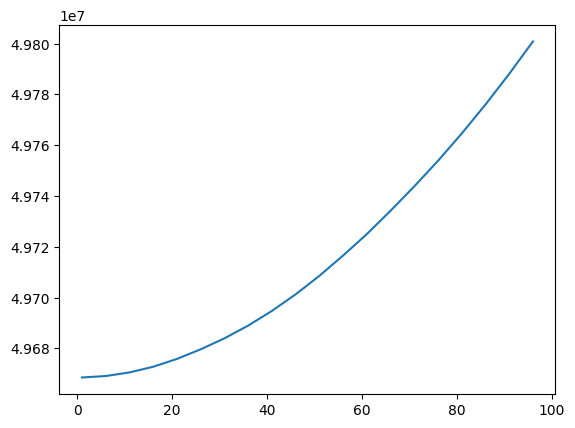

In [485]:
# Обучим регрессор LassoCV на всех параметрах регуляризации из alpha
# Построим график _усредненного_ по строкам MSE в зависимости от alpha.
# Выведим выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)

lasso_cv = LassoCV(alphas=alphas)
lasso_cv.fit(features_train, target_train)

means = np.mean(lasso_cv.mse_path_, axis=1)
plt.plot(lasso_cv.alphas_, means)

print("Best alpha: " + str(lasso_cv.alpha_))
list(zip(features_train.columns, lasso_cv.coef_))

In [486]:
lasso_regressor = Lasso(alpha=lasso_cv.alpha_)
lasso_regressor.fit(features_train, target_train)

Lasso(alpha=1)

In [487]:
lasso_submission = lasso_regressor.predict(features_train)

In [488]:
mean_absolute_percentage_error(lasso_submission, target_train)

1.192233190842857

In [365]:
sample_submission['sellingprice'] = lasso_regressor.predict(features_test)
sample_submission.to_csv('sample_submission.csv', index=False)